In [1]:
import pandas as pd
import numpy as np
import missingno as mo

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule
from sklearn.linear_model import LogisticRegression as Logit

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#plotting
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sn

# permutation
from sklearn.inspection import permutation_importance

## Load the Data

In [2]:
jordan = pd.read_csv("arabbaro/arabbaro_jo_labeled_reduced.csv")

In [3]:
jordan

,Unnamed: 0,income,in_capital,married,employed,employed_pub_sec,employed_priv_sec,selfemp,retired,housewife,...,infs_television,infs_socmed,country_of_origin_jordan,y_dem_top_issue,y_dem_pref,y_2_dem_pref_not_in_dem,y_1_distrust_gov,y_distrust_army,y_distrust_pres_prime,y_trust_ikhwan
0,1,500,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,2,200,True,True,False,False,False,False,False,True,...,False,True,False,False,True,False,True,False,False,False
2,3,850,True,True,False,False,False,False,False,True,...,False,False,False,False,True,True,True,False,False,False
3,4,200,False,True,True,False,True,False,False,False,...,False,True,True,False,False,False,True,False,False,False
4,5,650,False,True,False,False,False,True,False,False,...,False,True,False,False,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,2359,300,False,True,False,False,False,False,False,True,...,False,True,True,False,True,False,True,False,False,False
2359,2360,999,False,True,False,False,False,False,False,True,...,False,True,True,False,True,False,True,False,False,False
2360,2361,0,False,True,False,False,False,False,True,False,...,True,False,True,False,True,True,True,False,False,False
2361,2362,650,False,True,False,False,False,False,False,True,...,True,False,False,False,True,True,True,False,False,False


In [4]:
jordan.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

In [5]:
kuwait = pd.read_csv("arabbaro/arabbaro_kuw_labeled_reduced.csv")

In [6]:
kuwait.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [7]:
egypt = pd.read_csv("arabbaro/arabbaro_egy_labeled_reduced.csv")

In [8]:
egypt.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [9]:
morocco = pd.read_csv("arabbaro/arabbaro_mor_labeled_reduced.csv")

In [10]:
morocco.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [11]:
algeria = pd.read_csv("arabbaro/arabbaro_alg_labeled_reduced.csv")

In [12]:
algeria.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_distrust_army", "y_distrust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

## Functions Containing the Model and Related Metrics

In [13]:
def dempref(df):
    # set up SKLearn Framework
    y = df.y_2_dem_pref_not_in_dem
    if 'y_1_distrust_gov' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
    else:  
        X = df.drop(columns = "y_2_dem_pref_not_in_dem")

    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=1)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

In [14]:
def trustgov(df):
    # set up SKLearn Framework
    y = df.y_1_distrust_gov
    if 'y_2_dem_pref_not_in_dem' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
    else:  
        X = df.drop(columns = "y_1_distrust_gov")
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=1)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

## Run the Functions on the Data from Each Country

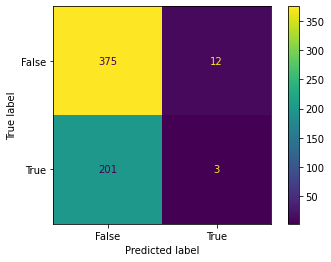

In [15]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(jordan)

In [16]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [17]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_DemPref_RF.csv")

In [18]:
score

0.5678315978682004

In [19]:
clf = RF(max_depth=6, max_features=5, n_estimators=500)

In [20]:
clf.fit(train_X,train_y)

RandomForestClassifier(max_depth=6, max_features=5, n_estimators=500)

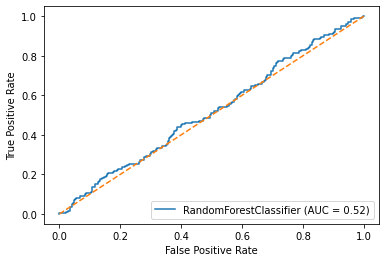

In [21]:
m.plot_roc_curve(clf, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.show()

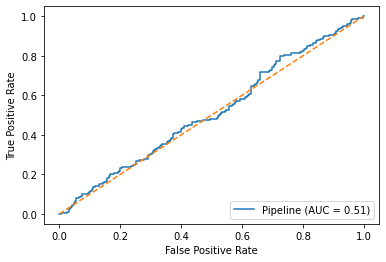

In [22]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [23]:
fig=plt.figure()
fig.show()

<Figure size 432x288 with 0 Axes>

In [24]:
print("hello world")

hello world


In [25]:
# Set the the first threshold as 0.8
threshold1 = 0.75

In [26]:
# Set the the first threshold as 0.8
threshold2 = 0.25

In [27]:
# use predict probabilities function
# First predictive threshold: 1 when greater than 80% probability
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [28]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [29]:
confusion_matrix_1.to_csv("Confusion_Matrices/Jordan_DemPref_RF_threshold_0.75.csv")

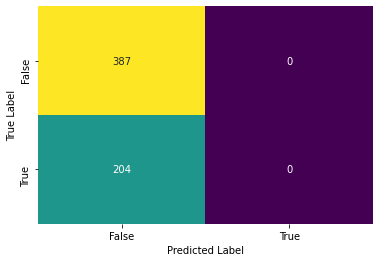

In [30]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [31]:
# Second predictive threshold: 0 when greater than 20% probability
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [32]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

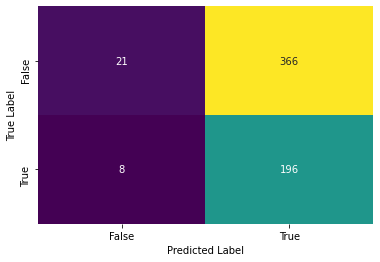

In [33]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [34]:
confusion_matrix_2.to_csv("Confusion_Matrices/Jordan_DemPref_RF_threshold_0.25.csv")

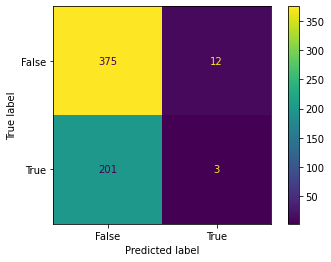

In [35]:
confusion.figure_

In [36]:
# show which model worked best
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [37]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [38]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.032054,0.001902,0.028250,0.035858
1,income,0.015350,0.001651,0.012048,0.018652
2,educ,0.013657,0.001651,0.010355,0.016959
3,male,0.013318,0.002539,0.008241,0.018396
4,internet_use_bin,0.012641,0.003083,0.006476,0.018807
5,unemp,0.011174,0.000749,0.009676,0.012671
6,neighb_rich,0.010609,0.000903,0.008804,0.012415
7,housewife,0.009029,0.002671,0.003688,0.014371
8,neighb_mixed,0.009029,0.001335,0.006358,0.011700
9,infs_socmed,0.008916,0.001401,0.006115,0.011718


In [39]:
vi_dat.to_csv("variable importance csv/jordan_y2")

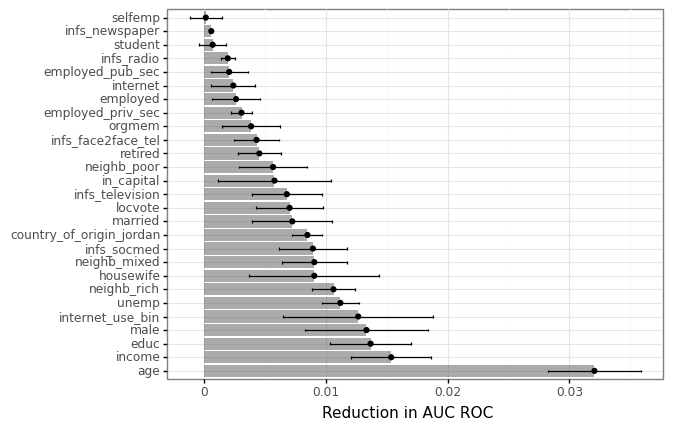

<ggplot: (8780105132132)>

In [40]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

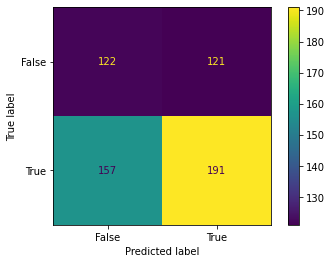

In [41]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(jordan)

In [42]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [43]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_TrustGov_RF.csv")

In [44]:
score

0.5752538157869221

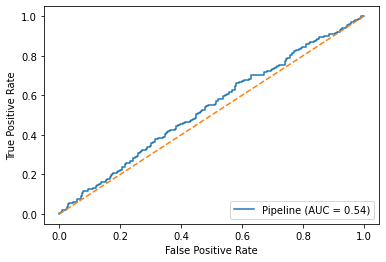

In [45]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

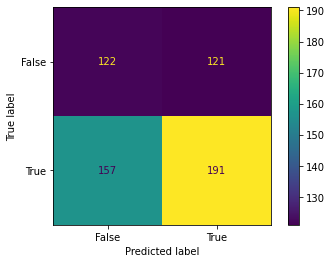

In [46]:
confusion.figure_

In [47]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [48]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [49]:
confusion_matrix_1.to_csv("Confusion_Matrices/Jordan_TrustGov_RF_threshold_0.75.csv")

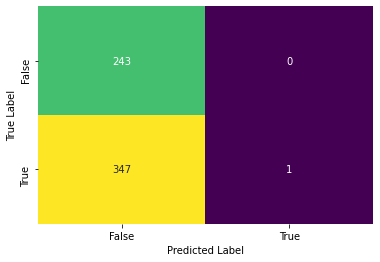

In [50]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [51]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [52]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [53]:
confusion_matrix_2.to_csv("Confusion_Matrices/Jordan_TrustGov_RF_threshold_0.25.csv")

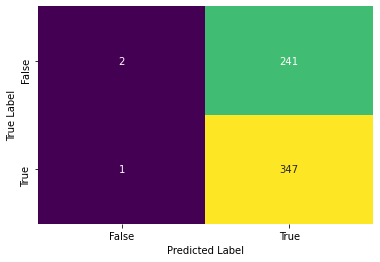

In [54]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [55]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', LogisticRegression(class_weight='balanced'))])

In [56]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [57]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,internet_use_bin,0.031603,0.007885,0.015834,0.047372
1,infs_socmed,0.022912,0.007449,0.008014,0.037810
2,retired,0.016366,0.005246,0.005875,0.026857
3,educ,0.012867,0.005335,0.002197,0.023536
4,infs_face2face_tel,0.009481,0.003699,0.002083,0.016879
5,male,0.005756,0.007274,-0.008793,0.020305
6,internet,0.005643,0.006274,-0.006905,0.018191
7,married,0.005643,0.001472,0.002700,0.008587
8,selfemp,0.005192,0.002405,0.000382,0.010002
9,employed_priv_sec,0.004289,0.003471,-0.002654,0.011232


In [58]:
vi_dat.to_csv("variable importance csv/jordan_y1")

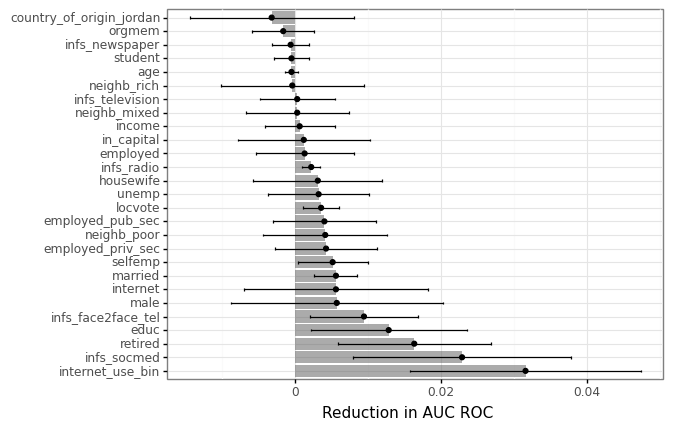

<ggplot: (8780090981096)>

In [59]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [60]:
kuwait.isna().sum()

below_medinc             0
above_medinc             0
in_capital               0
married                  0
employed                 0
employed_pub_sec         0
employed_priv_sec        0
selfemp                  0
retired                  0
housewife                0
student                  0
unemp                    0
neighb_rich           1304
neighb_poor           1304
neighb_mixed          1304
educ                     0
male                     0
age                      0
orgmem                   0
charity                  0
campaign_attend          0
locvote                  0
internet                 0
internet_use_bin         0
infs_face2face_tel       0
infs_newspaper           0
infs_radio               0
infs_television          0
infs_socmed              0
y_1_distrust_gov         0
dtype: int64

In [61]:
kuwait.drop(columns = ["neighb_rich", "neighb_poor", "neighb_mixed"], inplace = True)

In [62]:
kuwait

,below_medinc,above_medinc,in_capital,married,employed,employed_pub_sec,employed_priv_sec,selfemp,retired,housewife,...,campaign_attend,locvote,internet,internet_use_bin,infs_face2face_tel,infs_newspaper,infs_radio,infs_television,infs_socmed,y_1_distrust_gov
0,False,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True
1,False,True,False,True,True,True,False,False,False,False,...,True,True,True,1.0,False,False,False,False,True,False
2,False,False,False,True,False,False,False,False,True,False,...,False,False,True,0.8,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,True,False,...,True,True,True,1.0,False,False,False,False,True,True
4,True,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1300,False,True,False,True,True,False,True,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1301,False,False,False,True,True,False,True,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1302,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False


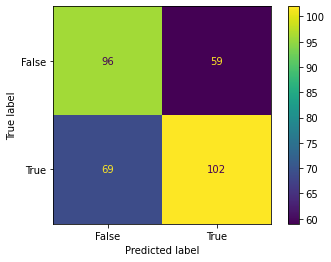

In [63]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(kuwait)

In [64]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [65]:
confusion_matrix.to_csv("Confusion_Matrices/Kuwait_TrustGov_RF.csv")

In [66]:
score

0.6520872442829756

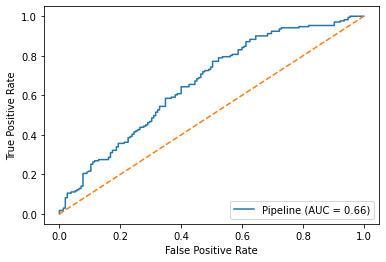

In [67]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

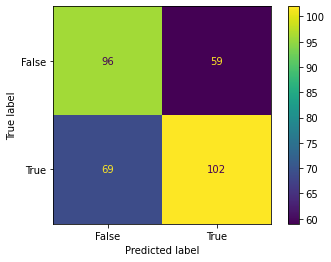

In [68]:
confusion.figure_

In [69]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [70]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [71]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [72]:
confusion_matrix_1.to_csv("Confusion_Matrices/Kuwait_TrustGov_RF_threshold_0.75.csv")

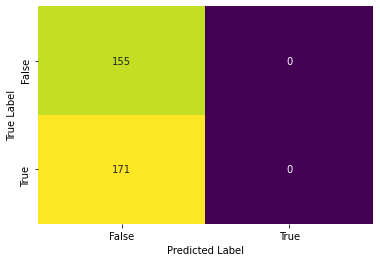

In [73]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [74]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [75]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [76]:
confusion_matrix_2.to_csv("Confusion_Matrices/Kuwait_TrustGov_RF_threshold_0.25.csv")

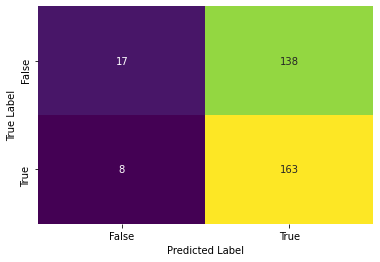

In [77]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [78]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [79]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_socmed,0.055624,0.006893,0.041839,0.069409
1,age,0.054806,0.003912,0.046981,0.062630
2,above_medinc,0.035174,0.007803,0.019567,0.050780
3,charity,0.028834,0.005578,0.017678,0.039990
4,housewife,0.020041,0.005434,0.009174,0.030908
5,locvote,0.019632,0.005067,0.009497,0.029766
6,educ,0.017791,0.003458,0.010875,0.024708
7,retired,0.015746,0.004822,0.006102,0.025390
8,student,0.015746,0.004778,0.006190,0.025303
9,in_capital,0.014724,0.001896,0.010931,0.018517


In [80]:
vi_dat.to_csv("variable importance csv/kuwait_y1")

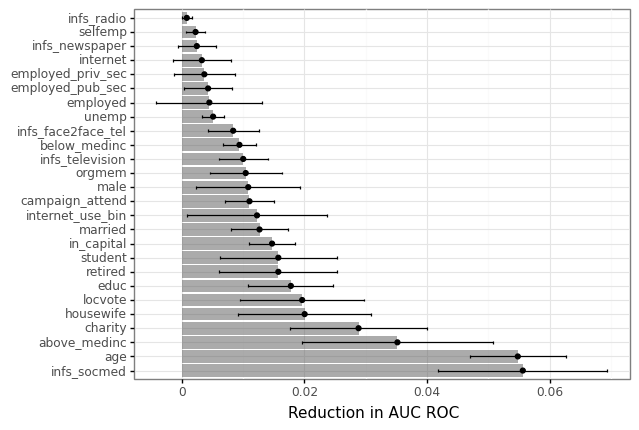

<ggplot: (8780091204630)>

In [81]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

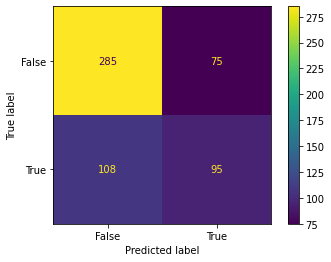

In [82]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(morocco)

In [83]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [84]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_DemPref_RF.csv")

In [85]:
score

0.7195098423854847

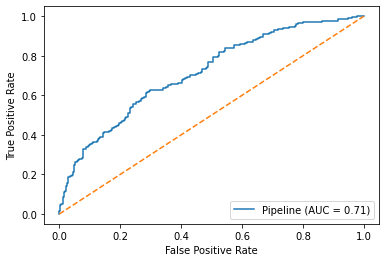

In [86]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

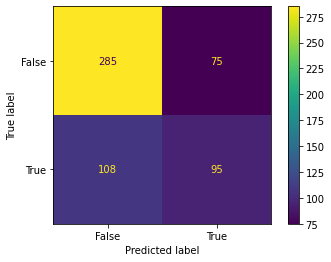

In [87]:
confusion.figure_

In [88]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [89]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [90]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [91]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocco_DemPref_threshold_0.75.csv")

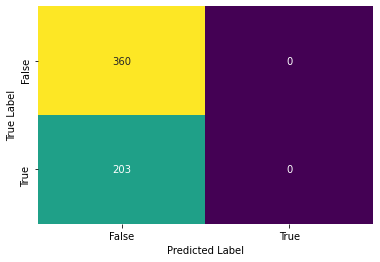

In [92]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [93]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [94]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [95]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocco_DemPref_threshold_0.25.csv")

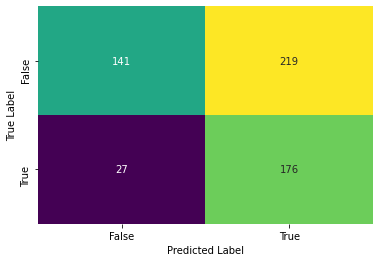

In [96]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [97]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [98]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,educ,0.042823,0.002168,0.038487,0.047159
1,age,0.024792,0.004082,0.016629,0.032956
2,internet_use_bin,0.022420,0.006111,0.010198,0.034642
3,male,0.016014,0.004244,0.007526,0.024502
4,internet,0.011981,0.003606,0.004769,0.019193
5,infs_socmed,0.010795,0.001210,0.008375,0.013214
6,petit,0.009846,0.002006,0.005834,0.013858
7,protest,0.009727,0.001221,0.007285,0.012170
8,unemp,0.009727,0.001528,0.006670,0.012784
9,orgmem,0.009015,0.001087,0.006841,0.011190


In [99]:
vi_dat.to_csv("variable importance csv/morocco_y2")

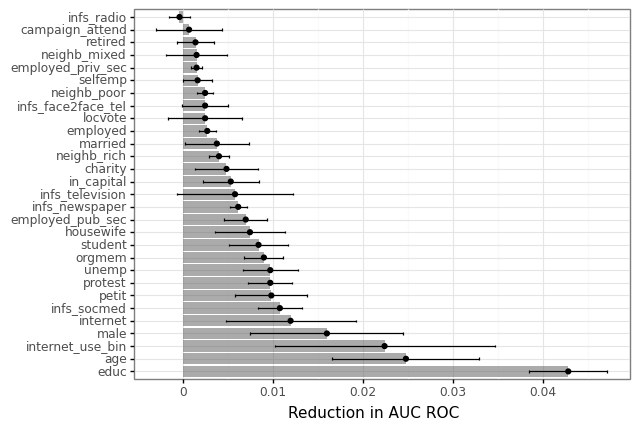

<ggplot: (8780091068645)>

In [100]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

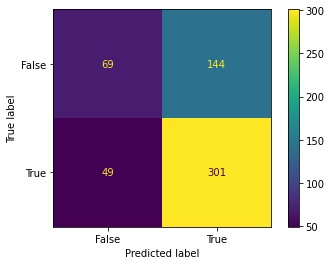

In [101]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(morocco)

In [102]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [103]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_TrustGov_RF.csv")

In [104]:
score

0.7391122637794542

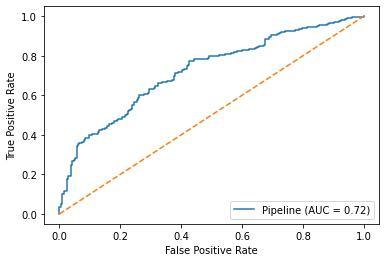

In [105]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

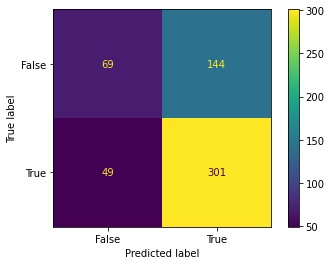

In [106]:
confusion.figure_

In [107]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, max_features=5,
                                        n_estimators=1500))])

In [108]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [109]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [110]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocco_TrustGov_threshold_0.75.csv")

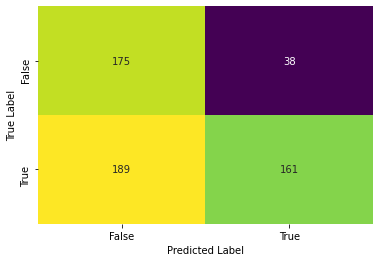

In [111]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [112]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [113]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [114]:
confusion_matrix_2.to_csv("Confusion_Matrices/Morocco_TrustGov_threshold_0.25.csv")

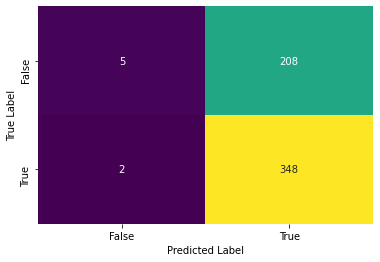

In [115]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [116]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [117]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.097509,0.001898,0.093713,0.101305
1,locvote,0.058363,0.003762,0.050838,0.065888
2,protest,0.031079,0.006515,0.018050,0.044109
3,educ,0.024318,0.001985,0.020348,0.028288
4,campaign_attend,0.024318,0.003637,0.017044,0.031592
5,infs_television,0.023369,0.003061,0.017246,0.029492
6,infs_socmed,0.016845,0.003531,0.009783,0.023906
7,charity,0.014472,0.003450,0.007572,0.021373
8,married,0.013642,0.000750,0.012141,0.015142
9,internet_use_bin,0.013286,0.002006,0.009274,0.017298


In [118]:
vi_dat.to_csv("variable importance csv/morocco_y1")

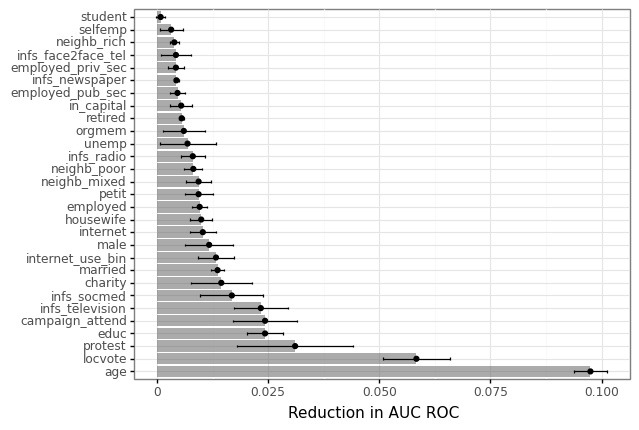

<ggplot: (8780091150445)>

In [119]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [120]:
egypt.drop(columns = "locvote", inplace = True)

In [121]:
egypt.dropna(inplace = True)

In [122]:
egypt.isna().sum()

income                     0
in_capital                 0
married                    0
employed                   0
employed_pub_sec           0
employed_priv_sec          0
selfemp                    0
retired                    0
housewife                  0
student                    0
unemp                      0
neighb_rich                0
neighb_poor                0
neighb_mixed               0
educ                       0
male                       0
age                        0
orgmem                     0
charity                    0
petit                      0
protest                    0
campaign_attend            0
internet                   0
internet_use_bin           0
infs_face2face_tel         0
infs_newspaper             0
infs_radio                 0
infs_television            0
infs_socmed                0
y_2_dem_pref_not_in_dem    0
y_1_distrust_gov           0
dtype: int64

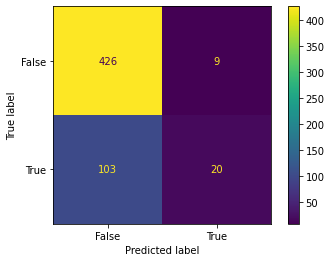

In [123]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(egypt)

In [124]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [125]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_DemPref_RF.csv")

In [126]:
score

0.7491781936056076

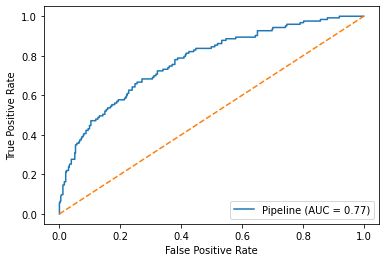

In [127]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

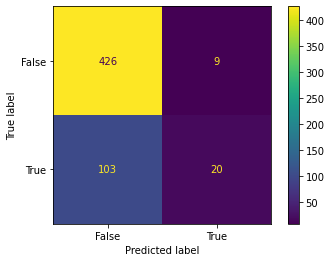

In [128]:
confusion.figure_

In [129]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=5,
                                        n_estimators=1500))])

In [130]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [131]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [132]:
confusion_matrix_1.to_csv("Confusion_Matrices/Egypt_DemPref_threshold_0.75.csv")

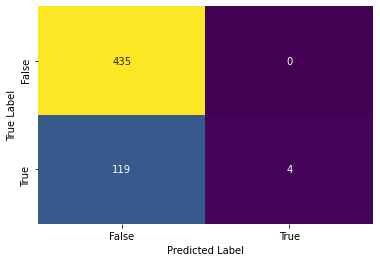

In [133]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [134]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [135]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [136]:
confusion_matrix_2.to_csv("Confusion_Matrices/Egypt_DemPref_threshold_0.25.csv")

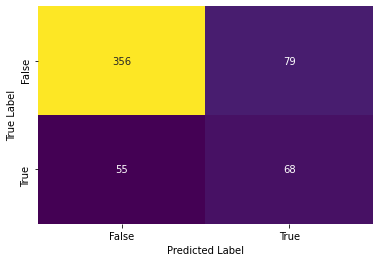

In [137]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [138]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [139]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,protest,0.022594,0.003010,0.016574,0.028614
1,infs_socmed,0.021877,0.002022,0.017833,0.025920
2,internet_use_bin,0.019247,0.002118,0.015010,0.023484
3,age,0.006336,0.001231,0.003874,0.008798
4,campaign_attend,0.006336,0.001540,0.003255,0.009416
5,petit,0.004423,0.000811,0.002802,0.006045
6,income,0.004304,0.001028,0.002247,0.006360
7,educ,0.004184,0.000535,0.003115,0.005253
8,orgmem,0.002989,0.001000,0.000988,0.004989
9,internet,0.001435,0.001288,-0.001141,0.004010


In [140]:
vi_dat.to_csv("variable importance csv/egypt_y2")

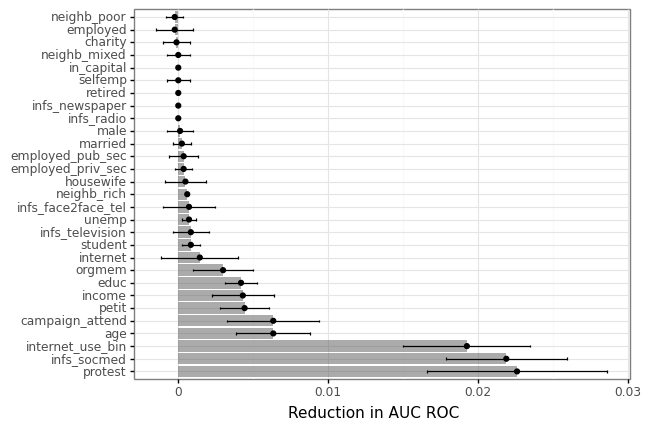

<ggplot: (8780038931219)>

In [141]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

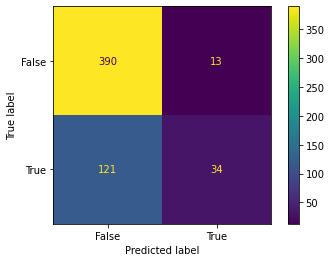

In [142]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(egypt)

In [143]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [144]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_TrustGov_RF.csv")

In [145]:
score

0.7178528797707681

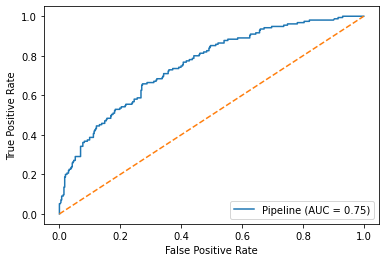

In [146]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

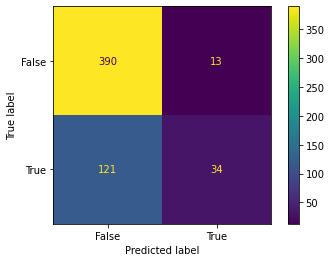

In [147]:
confusion.figure_

In [148]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, max_features=10,
                                        n_estimators=500))])

In [149]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [150]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [151]:
confusion_matrix_1.to_csv("Confusion_Matrices/Egypt_TrustGov_threshold_0.75.csv")

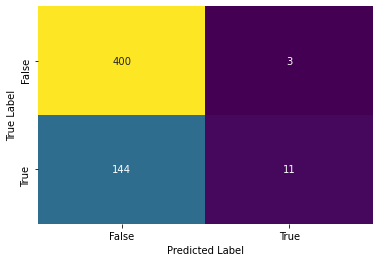

In [152]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [153]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [154]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [155]:
confusion_matrix_2.to_csv("Confusion_Matrices/Egypt_TrustGov_threshold_0.25.csv")

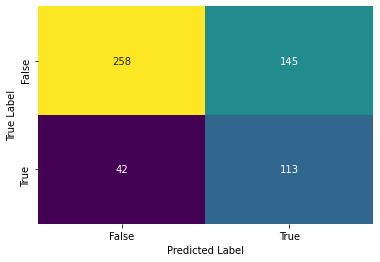

In [156]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [157]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [158]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,protest,0.045666,0.003457,0.038753,0.052579
1,age,0.043993,0.003638,0.036717,0.051268
2,income,0.033831,0.002409,0.029014,0.038649
3,infs_socmed,0.024387,0.003104,0.018180,0.030595
4,charity,0.023311,0.002000,0.019311,0.027312
5,infs_television,0.022714,0.004536,0.013641,0.031787
6,unemp,0.021996,0.002118,0.017760,0.026233
7,internet_use_bin,0.019845,0.001435,0.016975,0.022714
8,campaign_attend,0.016617,0.003844,0.008929,0.024305
9,male,0.012074,0.002737,0.006601,0.017547


In [159]:
vi_dat.to_csv("variable importance csv/egypt_y1")

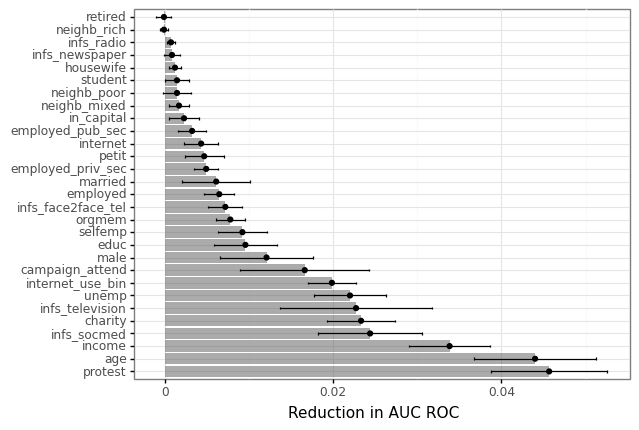

<ggplot: (8780038989120)>

In [160]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [161]:
algeria.dropna(inplace = True)

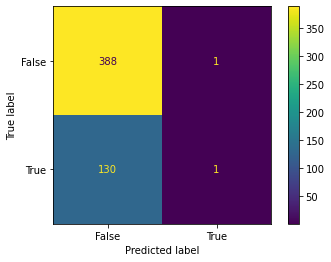

In [162]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(algeria)

In [163]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, best_mod.predict(test_X)))

In [164]:
confusion_matrix.to_csv("Confusion_Matrices/Algeria_DemPref_RF.csv")

In [165]:
score

0.610357171661742

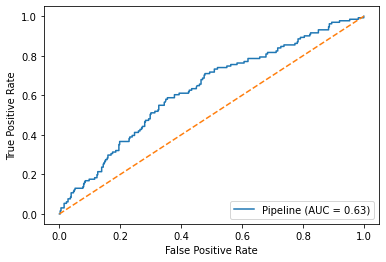

In [166]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

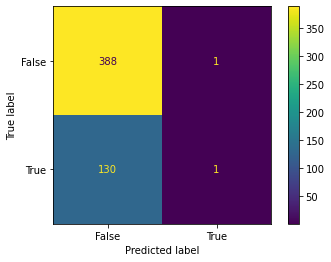

In [167]:
confusion.figure_

In [168]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=500))])

In [169]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [170]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [171]:
confusion_matrix_1.to_csv("Confusion_Matrices/Algeria_DemPref_threshold_0.75.csv")

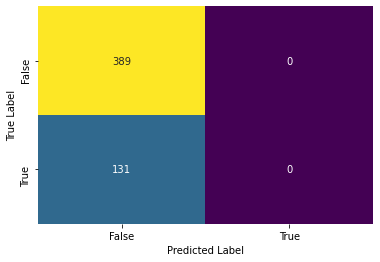

In [172]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [173]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [174]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [175]:
confusion_matrix_2.to_csv("Confusion_Matrices/Algeria_DemPref_threshold_0.25.csv")

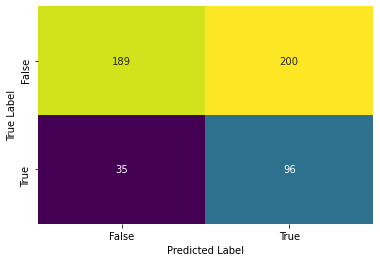

In [176]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [177]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [178]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.006936,0.000481,0.005975,0.007898
1,campaign_attend,0.004881,0.000871,0.003139,0.006624
2,educ,0.004753,0.001383,0.001986,0.007520
3,internet_use_bin,0.004110,0.001191,0.001728,0.006493
4,locvote,0.004110,0.000871,0.002368,0.005853
5,male,0.003982,0.000749,0.002484,0.005480
6,orgmem,0.003083,0.000749,0.001585,0.004581
7,charity,0.002569,0.000406,0.001757,0.003381
8,employed,0.002569,0.000406,0.001757,0.003381
9,infs_face2face_tel,0.002441,0.000481,0.001479,0.003402


In [179]:
vi_dat.to_csv("variable importance csv/algeria_y2")

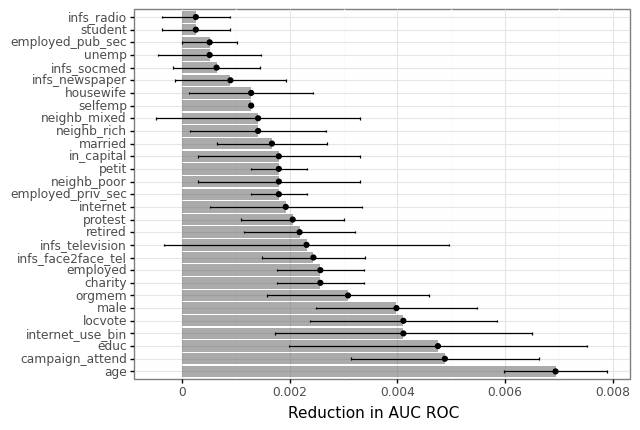

<ggplot: (8780038871664)>

In [180]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

## Logit Models

In [181]:
# train-test split
y = jordan.y_2_dem_pref_not_in_dem
X = jordan.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [182]:
LogitR = Logit(class_weight = 'balanced')

In [183]:
clf = LogitR.fit(train_X, train_y)

In [184]:
pred_y= clf.predict(test_X)

In [185]:
m.roc_auc_score(test_y, pred_y)

0.4907470740234078

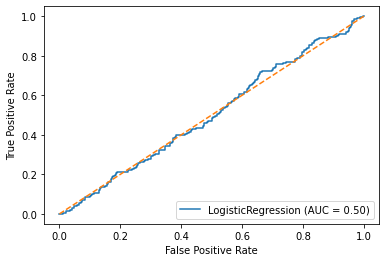

In [186]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [187]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [188]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_DemPref_Logit.csv")

In [189]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [190]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [192]:
confusion_matrix_1.to_csv("Confusion_Matrices/Jordan_DemPref_Logit_threshold_0.75.csv")

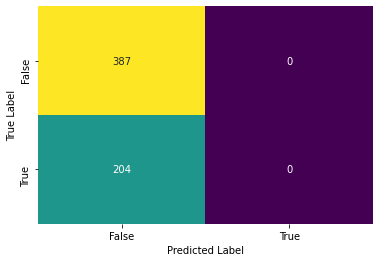

In [194]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [195]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [196]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [197]:
confusion_matrix_2.to_csv("Confusion_Matrices/Jordan_DemPref_Logit_threshold_0.25.csv")

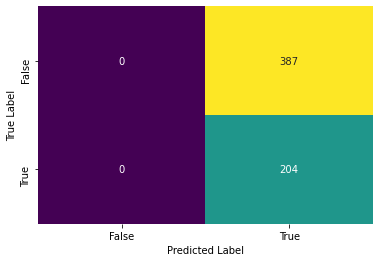

In [199]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [212]:
# train-test split
y = jordan.y_1_distrust_gov
X = jordan.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [213]:
clf = LogitR.fit(train_X, train_y)

In [214]:
pred_y= clf.predict(test_X)

In [215]:
m.roc_auc_score(test_y, pred_y)

0.5357421597843053

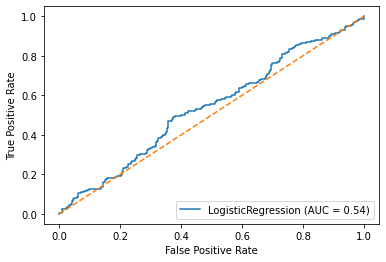

In [216]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [217]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [200]:
confusion_matrix.to_csv("Confusion_Matrices/Jordan_TrustGov_Logit.csv")

In [201]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [202]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [203]:
confusion_matrix_1.to_csv("Confusion_Matrices/Jordan_TrustGov_Logit_threshold_0.75.csv")

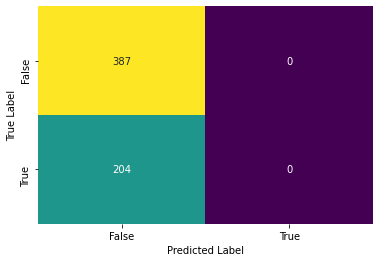

In [204]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [205]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [206]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [207]:
confusion_matrix_2.to_csv("Confusion_Matrices/Jordan_TrustGov_Logit_threshold_0.25.csv")

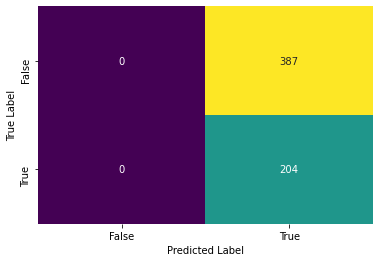

In [208]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [209]:
# train-test split
y = kuwait.y_1_distrust_gov
X = kuwait.drop(columns = ["y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [210]:
clf = LogitR.fit(train_X, train_y)

In [211]:
pred_y= clf.predict(test_X)

In [212]:
m.roc_auc_score(test_y, pred_y)

0.5

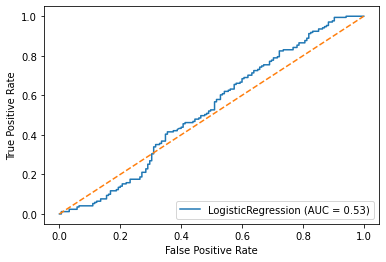

In [213]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [214]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [215]:
confusion_matrix.to_csv("Confusion_Matrices/Kuwait_TrustGov_Logit.csv")

In [216]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [217]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [218]:
confusion_matrix_1.to_csv("Confusion_Matrices/Kuwait_TrustGov_Logit_threshold_0.75.csv")

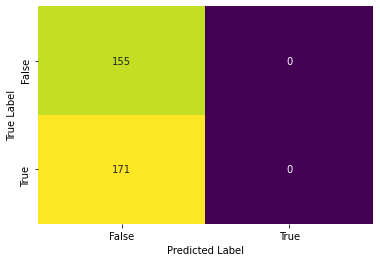

In [219]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [220]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [221]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [222]:
confusion_matrix_2.to_csv("Confusion_Matrices/Kuwait_TrustGov_Logit_threshold_0.25.csv")

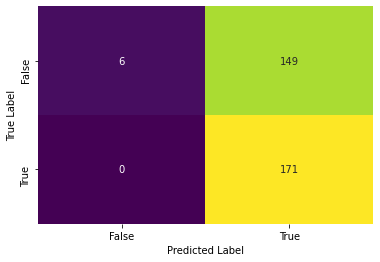

In [223]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [224]:
# train-test split
y = morocco.y_2_dem_pref_not_in_dem
X = morocco.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [225]:
clf = LogitR.fit(train_X, train_y)

In [226]:
pred_y= clf.predict(test_X)

In [227]:
m.roc_auc_score(test_y, pred_y)

0.6481800766283524

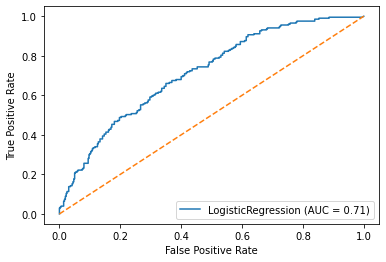

In [228]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [229]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [230]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_DemPref_Logit.csv")

In [231]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [232]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [233]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocoo_DemPref_Logit_threshold_0.75.csv")

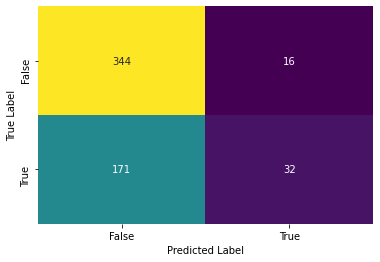

In [234]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [235]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [236]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [237]:
confusion_matrix_2.to_csv("Confusion_Matrices/Morocco_DemPref_Logit_threshold_0.25.csv")

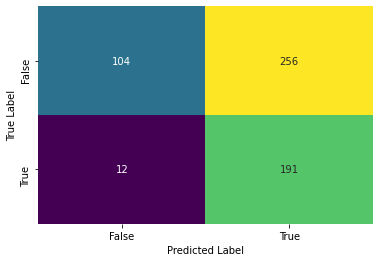

In [238]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [239]:
# train-test split
y = morocco.y_1_distrust_gov
X = morocco.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [240]:
clf = LogitR.fit(train_X, train_y)

In [241]:
pred_y= clf.predict(test_X)

In [242]:
m.roc_auc_score(test_y, pred_y)

0.6411871227364185

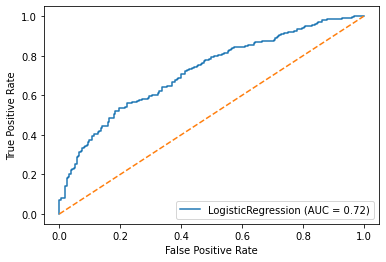

In [243]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [244]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [245]:
confusion_matrix.to_csv("Confusion_Matrices/Morocco_TrustGov_Logit.csv")

In [246]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [247]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [248]:
confusion_matrix_1.to_csv("Confusion_Matrices/Morocoo_TrustGov_Logit_threshold_0.75.csv")

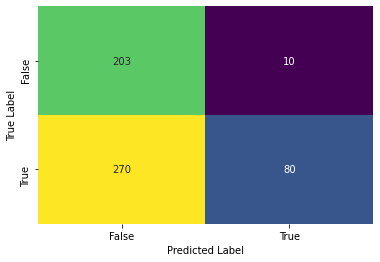

In [249]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [250]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [251]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [252]:
confusion_matrix_2.to_csv("Confusion_Matrices/Morocco_TrustGov_Logit_threshold_0.25.csv")

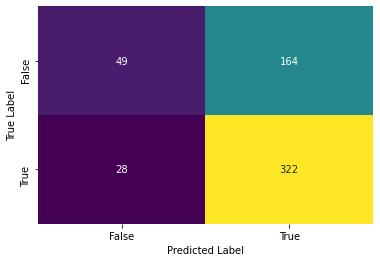

In [253]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [254]:
# train-test split
y = egypt.y_2_dem_pref_not_in_dem
X = egypt.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [255]:
clf = LogitR.fit(train_X, train_y)

In [256]:
pred_y= clf.predict(test_X)

In [257]:
m.roc_auc_score(test_y, pred_y)

0.6913372582001682

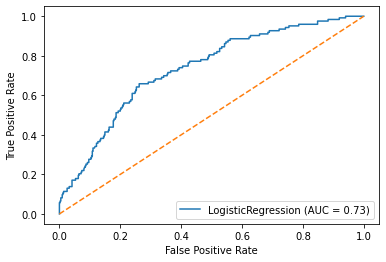

In [258]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [259]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [260]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_DemPref_Logit.csv")

In [261]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [262]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [263]:
confusion_matrix_1.to_csv("Confusion_Matrices/Egypt_DemPref_Logit_threshold_0.75.csv")

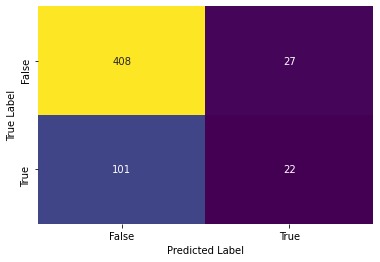

In [264]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [265]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [266]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [267]:
confusion_matrix_2.to_csv("Confusion_Matrices/Egypt_DemPref_Logit_threshold_0.25.csv")

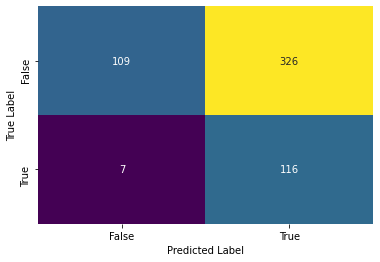

In [268]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [269]:
# train-test split
y = egypt.y_1_distrust_gov
X = egypt.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [270]:
clf = LogitR.fit(train_X, train_y)

In [271]:
pred_y= clf.predict(test_X)

In [272]:
m.roc_auc_score(test_y, pred_y)

0.6754342431761786

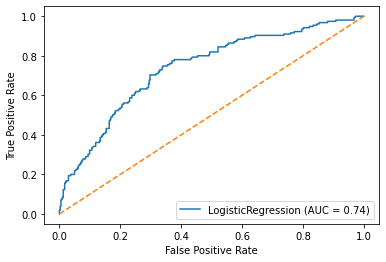

In [273]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [274]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [275]:
confusion_matrix.to_csv("Confusion_Matrices/Egypt_TrustGov_Logit.csv")

In [276]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [277]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [278]:
confusion_matrix_1.to_csv("Confusion_Matrices/Egypt_TrustGov_Logit_threshold_0.75.csv")

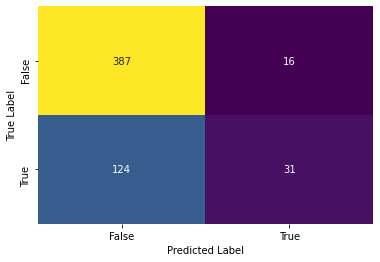

In [279]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [280]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [281]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [282]:
confusion_matrix_2.to_csv("Confusion_Matrices/Egypt_TrustGov_Logit_threshold_0.25.csv")

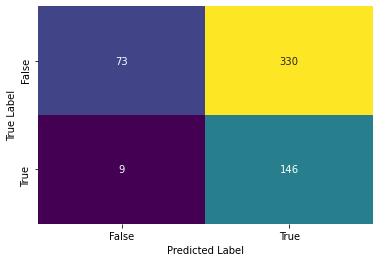

In [283]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [284]:
# train-test split
y = algeria.y_2_dem_pref_not_in_dem
X = algeria.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_distrust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [285]:
clf = LogitR.fit(train_X, train_y)

In [286]:
pred_y= clf.predict(test_X)

In [287]:
m.roc_auc_score(test_y, pred_y)

0.6240310838124766

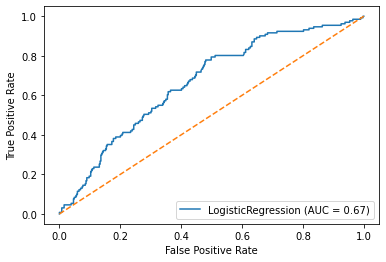

In [288]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [289]:
confusion_matrix = pd.DataFrame(m.confusion_matrix(test_y, pred_y))

In [290]:
confusion_matrix.to_csv("Confusion_Matrices/Algeria_DemPref_Logit.csv")

In [291]:
pred_threshold1 = (clf.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [292]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

In [293]:
confusion_matrix_1.to_csv("Confusion_Matrices/Algeria_DemPref_Logit_threshold_0.75.csv")

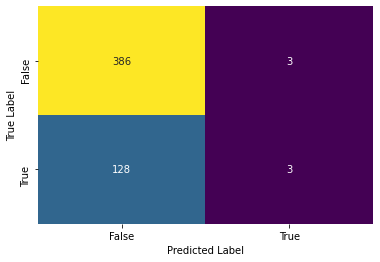

In [294]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [295]:
pred_threshold2 = (clf.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [296]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

In [297]:
confusion_matrix_2.to_csv("Confusion_Matrices/Algeria_DemPref_Logit_threshold_0.25.csv")

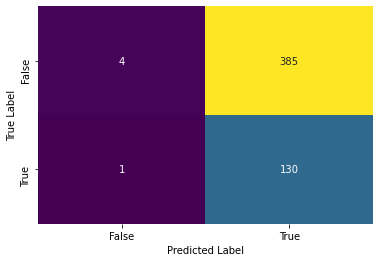

In [298]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()